Starting training [mean]:
Epoch [1/1000], Loss: 0.4076
Epoch [101/1000], Loss: 0.1795
Epoch [201/1000], Loss: 0.0094
Epoch [301/1000], Loss: 0.0039
Epoch [401/1000], Loss: 0.0036
Epoch [501/1000], Loss: 0.0034
Epoch [601/1000], Loss: 0.0036
Epoch [701/1000], Loss: 0.0054
Epoch [801/1000], Loss: 0.0042
Epoch [901/1000], Loss: 0.0042
Validation:
Validation loss over 1000 vectors for function mean: 0.0055
Starting training [median]:
Epoch [1/1000], Loss: 0.1211
Epoch [101/1000], Loss: 0.0159
Epoch [201/1000], Loss: 0.0113
Epoch [301/1000], Loss: 0.0119
Epoch [401/1000], Loss: 0.0108
Epoch [501/1000], Loss: 0.0101
Epoch [601/1000], Loss: 0.0087
Epoch [701/1000], Loss: 0.0126
Epoch [801/1000], Loss: 0.0115
Epoch [901/1000], Loss: 0.0077
Validation:
Validation loss over 1000 vectors for function median: 0.0090
Starting training [max]:
Epoch [1/1000], Loss: 0.6823
Epoch [101/1000], Loss: 0.3536
Epoch [201/1000], Loss: 0.0284
Epoch [301/1000], Loss: 0.0289
Epoch [401/1000], Loss: 0.0258
Epoch 

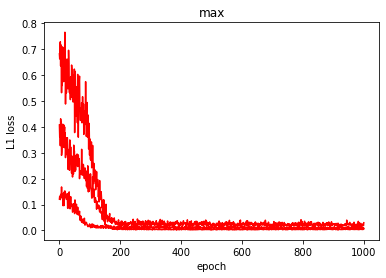

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from dlquantification.quantmodule.histograms.HardHistogram import HardHistogram
import matplotlib.pyplot as plt


def generate_data(num_vectors, vector_size, function_to_learn):
    random_numbers = []
    # generate random input tensor of shape (batch_size, input_size)
    # generate a random maximum value between 0 and 100
    # generate a random maximum value between 0 and 100
    for i in range(num_vectors):
        max_value = torch.rand(size=(1,)).item()
        # generate a tensor of 100 random integers between 0 and the maximum value
        row_numbers = torch.rand(size=(vector_size,1))*max_value
        random_numbers.append(row_numbers)
        
    input_tensor = torch.cat(random_numbers, dim=0).view(num_vectors,vector_size)
    # compute the maximum value of each input tensor
    if function_to_learn=='max':
        target = torch.max(input_tensor, dim=1)[0].view(num_vectors,1)
    elif function_to_learn=='mean':
        target = torch.mean(input_tensor, dim=1).view(num_vectors,1)
    elif function_to_learn=='median':
        target = torch.median(input_tensor, dim=1)[0].view(num_vectors,1)

    return input_tensor, target

    

class MaxNet(nn.Module):
    def __init__(self, input_size, use_histogram=False):
        super(MaxNet, self).__init__()
        self.input_size = input_size
        self.use_histogram = use_histogram
        if use_histogram:
            self.histogram = HardHistogram(n_features=1,num_bins=64)
            self.fc1 = nn.Linear(64, 32)
        else:
            self.fc1 = nn.Linear(100,32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        if self.use_histogram:
            x = self.histogram(x.view(x.shape[0],self.input_size,1))
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
torch.manual_seed(0)

# set the batch size and number of epochs
batch_size = 20
vector_size = 100
num_epochs = 1000

for function_to_learn in ["mean", "median", "max"]:
    # create an instance of the network
    net = MaxNet(input_size=vector_size,use_histogram=True)

    # define the loss function and optimizer
    criterion = nn.L1Loss()
    optimizer = optim.AdamW(net.parameters(), lr=0.0005)

    print("Starting training [%s]:" % function_to_learn)
    losses = []
    # iterate over the dataset for the specified number of epochs
    for epoch in range(num_epochs):
        input_tensor, target = generate_data(batch_size, vector_size, function_to_learn)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = net(input_tensor)
        #print("expected:",target,"got",output)
        loss = criterion(output, target)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

        # print statistics
        if epoch % 100 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
    plt.plot(losses, color='red')
    plt.title(function_to_learn)
    plt.xlabel('epoch')
    plt.ylabel('L1 loss')

    print("Validation:")
    input_tensor, target = generate_data(1000, vector_size, function_to_learn)
    net.eval()
    with torch.no_grad():
        output = net(input_tensor)
        loss = criterion(output, target)
        print("Validation loss over 1000 vectors for function %s: %.4f" % (function_to_learn, loss.item()))
